# Invasive Species Monitoring

## Import

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Lambda, Flatten, Dense, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.optimizers import RMSprop, Adam, SGD
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

## Functions

In [4]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [7]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

## Split labels

In [7]:
import pandas as pd
import os, sys
import shutil

In [8]:
path = "data/invasive/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [9]:
%cd $path

/home/ubuntu/courses/nbs/data/invasive


In [10]:
%mkdir train/c0
%mkdir train/c1
%mkdir test/unknown

In [52]:
%mv test/*.jpg test/unknown

In [53]:
%ls test/unknown/ | wc -l

1531


In [11]:
%ls -alt

total 160
drwx------ 3 ubuntu ubuntu 36864 Jul 22 11:01 test/
drwx------ 4 ubuntu ubuntu 69632 Jul 22 11:01 train/
drwxrwxr-x 5 ubuntu ubuntu  4096 Jul 22 11:00 ./
drwxrwxr-x 2 ubuntu ubuntu  4096 Jul 22 10:59 models/
drwxrwxr-x 6 ubuntu ubuntu  4096 Jul 21 17:52 ../
-rw-r--r-- 1 ubuntu ubuntu 17268 May  3 23:30 train_labels.csv
-rw-r--r-- 1 ubuntu ubuntu 14218 May  3 23:26 sample_submission.csv


In [12]:
labels = pd.read_csv('train_labels.csv').set_index('name')

In [13]:
labels.head()

,invasive
name,
1,0
2,0
3,1
4,0
5,1


In [29]:
%pwd

u'/home/ubuntu/courses/nbs/data/invasive'

In [43]:
for root, subFolders, files in os.walk('train/'):
    for f in files:
        n = int(f[:f.find(".")])
        if labels.loc[n, 'invasive']:
            shutil.move('train/'+f, 'train/c1/'+f)
        else:
            shutil.move('train/'+f, 'train/c0/'+f)
    break

In [45]:
%ls -alt train/

total 160
drwx------ 4 ubuntu ubuntu 69632 Jul 22 11:28 ./
drwxrwxr-x 2 ubuntu ubuntu 28672 Jul 22 11:28 c0/
drwxrwxr-x 2 ubuntu ubuntu 49152 Jul 22 11:28 c1/
drwxrwxr-x 5 ubuntu ubuntu  4096 Jul 22 11:00 ../


In [48]:
%ls train/c0 | wc -l

847


In [50]:
len(labels[labels['invasive']==0])

847

In [49]:
%ls train/c1 | wc -l

1448


In [51]:
len(labels[labels['invasive']==1])

1448

## Split validation set

In [54]:
from glob import glob

In [56]:
%mkdir valid
%mkdir valid/c0
%mkdir valid/c1

In [57]:
DATA_HOME_DIR = os.getcwd()

In [65]:
%cd train/

/home/ubuntu/courses/nbs/data/invasive/train


In [66]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): shutil.move(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [67]:
%cd $DATA_HOME_DIR

/home/ubuntu/courses/nbs/data/invasive


In [68]:
%ls train/c0 | wc -l
%ls valid/c0 | wc -l

662
185


In [69]:
%ls train/c1 | wc -l
%ls valid/c1 | wc -l

1133
315


## Plot images

In [14]:
import matplotlib.image as mpimg

In [23]:
ims = ['train/1.jpg', 'train/4.jpg', 'train/3.jpg', 'train/5.jpg']
ims = [mpimg.imread(i) for i in ims]

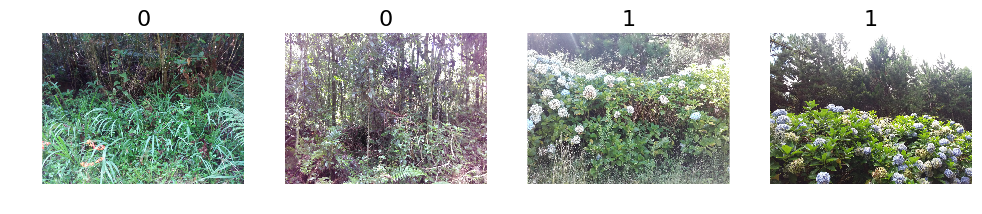

In [26]:
plots(ims, titles=[0,0,1,1])

## Batches

In [8]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [9]:
batch_size=64

In [11]:
path = 'data/invasive/'

In [12]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 1795 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [13]:
test_batches = get_batches(path + 'test', shuffle=False, batch_size=1)

Found 1531 images belonging to 1 classes.


In [14]:
from keras.utils.np_utils import to_categorical
trn_labels = to_categorical(batches.classes)
val_labels = to_categorical(val_batches.classes)

## VGG Model

In [146]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [147]:
def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))

In [148]:
def FCBlock(model, bn=True):
    model.add(Dense(4096, activation='relu'))
    if bn:
        model.add(BatchNormalization())
    model.add(Dropout(0.5))

In [20]:
# Create a VGG16 model with the original ImageNet weights
model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

model.add(Flatten())

FCBlock(model, bn=False)
FCBlock(model, bn=False)

model.add(Dense(1000, activation='softmax'))

In [21]:
model.load_weights('/home/ubuntu/.keras/models/vgg16.h5')

In [22]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metric=['accuracy'])

## Convolutional Model - Bottleneck Features

In [21]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [29]:
#Create a convolution-only model for obtaining bottleneck features
conv_model = Sequential(conv_layers)

In [31]:
gen_t = image.ImageDataGenerator(rotation_range=5, height_shift_range=0.1, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1,
                zoom_range=0.05, horizontal_flip=True)

In [45]:
da_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

Found 1795 images belonging to 2 classes.


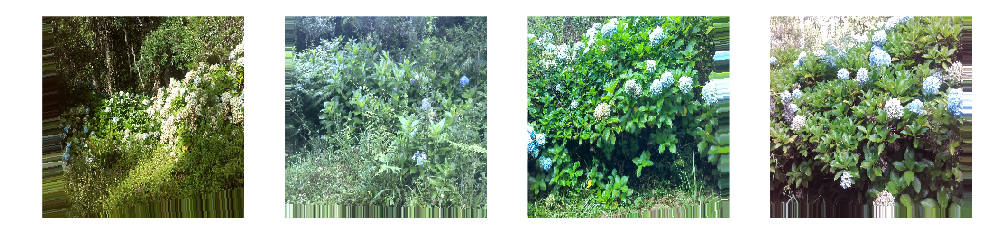

In [44]:
plots(next(da_batches)[0][:4])

In [46]:
conv_feat = conv_model.predict_generator(da_batches, batches.nb_sample*5)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [49]:
save_array(path+'models/conv_val_feat.dat', conv_val_feat)
save_array(path+'models/conv_feat.dat', conv_feat)

In [16]:
conv_val_feat = load_array(path + 'models/conv_val_feat.dat')
conv_feat = load_array(path + 'models/conv_feat.dat')

In [17]:
da_trn_labels = np.concatenate([trn_labels]*5)

## Fully-Connected with BatchNormalization

In [18]:
# Create the complete VGG16 model with Batch Normalization
model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

ConvBlock(model, 2, 64)
ConvBlock(model, 2, 128)
ConvBlock(model, 3, 256)
ConvBlock(model, 3, 512)
ConvBlock(model, 3, 512)

model.add(Flatten())

FCBlock(model)
FCBlock(model)

model.add(Dense(1000, activation='softmax'))

model.load_weights('/home/ubuntu/.keras/models/vgg16_bn.h5')

In [22]:
# Obtain the fully connected layers and pop the very last layer
fc_layers = model.layers[last_conv_idx+3:]
fc_layers.pop()

In [24]:
fc_layers

In [25]:
# Create a Fully-Connected model
fc_model = Sequential()

fc_model.add(MaxPooling2D((2,2),strides=(2,2), input_shape=conv_feat.shape[1:]))
fc_model.add(Flatten())

FCBlock(fc_model)
FCBlock(fc_model)

fc_model.add(Dense(2, activation='softmax'))

In [26]:
fc_model.compile(optimizer=Adam(lr=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
def copy_weights(from_layers, to_layers):
    for from_layer,to_layer in zip(from_layers, to_layers):
        to_layer.set_weights(from_layer.get_weights())

In [83]:
# Initialize the Fully-Connected model with ImageNet weights
copy_weights(fc_layers, fc_model.layers[2:8])
fc_model.save_weights(path+'models/initial_weights.h5')

In [27]:
fc_model.load_weights(path+'models/initial_weights.h5')

In [87]:
fc_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_18 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_3[0][0]       
____________________________________________________________________________________________________
flatten_6 (Flatten)              (None, 25088)         0           maxpooling2d_18[0][0]            
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 4096)          102764544   flatten_6[0][0]                  
____________________________________________________________________________________________________
batchnormalization_5 (BatchNormal(None, 4096)          8192        dense_11[0][0]                   
___________________________________________________________________________________________

In [28]:
# Check if weights are identical
fc_layers[0].get_weights()[0][0] == fc_model.layers[2].get_weights()[0][0]

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

### Train

In [29]:
# Ran this several times
fc_model.fit(conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 8975 samples, validate on 500 samples
Epoch 1/2
8975/8975 [==============================] - 16s - loss: 1.7188 - acc: 0.6172 - val_loss: 0.5502 - val_acc: 0.7940
Epoch 2/2
8975/8975 [==============================] - 16s - loss: 1.2841 - acc: 0.7164 - val_loss: 0.5679 - val_acc: 0.8180


In [81]:
# lr = 1e-6 - no overfit
fc_model.save_weights(path+'models/weights_1.h5')

In [136]:
# lr = 1e-6 - little overfit, improved ROC
fc_model.save_weights(path+'models/weights_2.h5')

### Evaluate

In [137]:
pr = fc_model.predict(conv_val_feat, batch_size=256)
roc_auc_score(val_batches.classes, pr[:,1])

0.99404547404547405

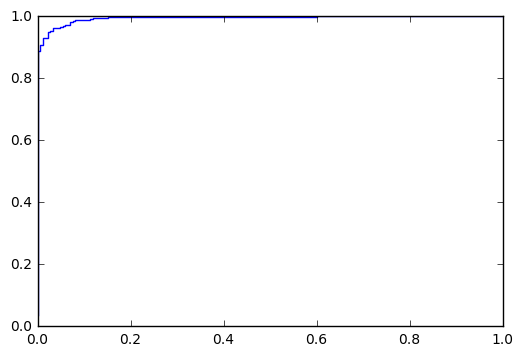

In [138]:
fpr, tpr, thresholds = roc_curve(val_batches.classes, pr[:,1])
plt.plot(fpr,tpr)

## Ensemble

In [154]:
def create_fc_model():
    model = Sequential([
            MaxPooling2D((2,2),strides=(2,2), input_shape=conv_feat.shape[1:]),
            Flatten(),
            Dense(4096, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(4096, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(2, activation='softmax')
        ])
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights(path+'models/initial_weights.h5')
    return model

In [155]:
def fit_model():
    model = create_fc_model()
    model.fit(conv_feat, da_trn_labels, batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, val_labels), verbose=0)
    return model

In [156]:
models = [fit_model() for i in range(6)]

In [157]:
all_preds = np.stack([m.predict(conv_val_feat, batch_size=256) for m in models])
avg_preds = all_preds.mean(axis=0)

In [176]:
preds = do_clip(avg_preds[:,1],0.95)

In [177]:
roc_auc_score(val_batches.classes, preds)

0.97187473187473195

In [165]:
fpr, tpr, thresholds = roc_curve(val_batches.classes, preds)

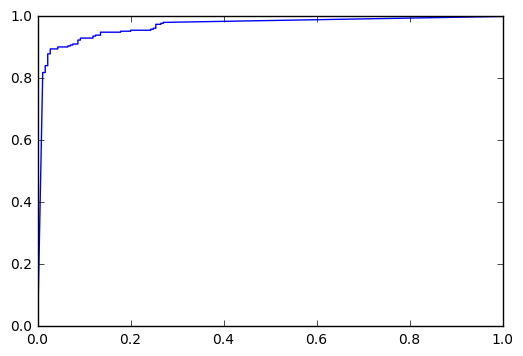

In [166]:
plt.plot(fpr, tpr)

## Submit

In [38]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)

In [139]:
val_preds = fc_model.predict(conv_val_feat, batch_size=2*batch_size)[:,1]

In [140]:
roc_auc_score(val_batches.classes, do_clip(val_preds, 0.95))

0.99390819390819396

In [109]:
conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)

In [110]:
save_array(path+'models/conv_test_feat.dat', conv_test_feat)

In [95]:
conv_test_feat = load_array(path+'models/conv_test_feat.dat')

In [141]:
preds = fc_model.predict(conv_test_feat, batch_size=batch_size*2)

In [114]:
sample = pd.read_csv(path+'sample_submission.csv')
sample.head()

,name,invasive
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [179]:
all_preds = np.stack([m.predict(conv_test_feat, batch_size=256) for m in models])
preds = all_preds.mean(axis=0)

In [142]:
ids = np.array([int(f[8:f.find('.')]) for f in test_batches.filenames])
isInvasive = do_clip(preds[:,1],0.95)

In [143]:
subm = np.stack([ids,isInvasive], axis=1)

In [144]:
submission_file_name = 'submission4.csv'
np.savetxt(path+submission_file_name, subm, fmt='%d,%.5f', header='name,invasive', comments='')

In [183]:
pd.read_csv(path+submission_file_name).head()

,name,invasive
0,779,0.95000
1,1261,0.00806
2,878,0.00556
3,552,0.95000
4,400,0.30483


In [145]:
from IPython.display import FileLink
FileLink(path+submission_file_name)

/home/ubuntu/courses/nbs/data/invasive/submission4.csv